In [12]:
import pandas as pd
import spacy
from spacy.lang.en import English
import collections
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [13]:
# General framework for entities using spacy
# Define labels e.g. stocks are 'EQ', companies are 'ORG', people are 'PERSON' etc
# Can either add this to an existing model or start from blank (depending on use case)
# For now we will add a list of common entities found in WSB 'hot' ; this can be incremented daily / adhoc

# Components are:
# 1. Create blank model and add entity ruler OR load entity ruler
# 2. Generate a pattern for an entity and add to ruler
# 3. Save ruler

# For 2, we adopt the following convention (primarily for the purpose of Reddit)
# For a stock, <LABEL> = 'EQ'
# {'label': <LABEL>, 'id': <UNIQUE NAME>, 'pattern':[{'lower':<NAME TO LOOK FOR IN DATA>}]},
# If a stock, also add {'label': <LABEL>, 'id': <UNIQUE NAME>, 'pattern':[{'lower':<STOCK TICKER>}]}

In [14]:
# Utilities

def load_ruler(path):
    '''Requires import spacy, used to load EntityRuler'''
    return EntityRuler.from_disk(path)

def save_ruler(path):
    '''Requires import spacy, used to load EntityRuler'''
    return EntityRuler.to_disk(path)

def gen_pattern(entity_label, id_entity, ticker = None):
    '''Generates a pattern in format required by spacy'''
    
    # Figure out words in name
    name_words = id_entity.split()
    pat = []
    for i in name_words:
        pat.append({'lower':str(i).lower()})
    
    if entity_label in ['EQ','ETF','INDEX']:
        # To do: raise exception if ticker = None in this case
        if ticker == None:
            print('ERROR with entity {} with ticker = None'.format(id_entity))
            return
        
        return [{'label':entity_label, 'id':id_entity, 'pattern':pat},
               {'label':entity_label, 'id':id_entity, 'pattern':[{'lower':str(ticker).lower()}]}]
    
    # If we decide to use a ticker nevertheless e.g. RobinHood = RH then
    if ticker != None:
        return [{'label':entity_label, 'id':id_entity, 'pattern':pat},
               {'label':entity_label, 'id':id_entity, 'pattern':[{'lower':str(ticker).lower()}]}]
            
    return [{'label':entity_label, 'id':id_entity, 'pattern':pat}]

def add_to_ruler(ruler, pattern_to_add):
    '''Add the pattern to the EntityRuler'''
    ruler.add_patterns(pattern_to_add)

In [15]:
df_wsb = pd.read_csv('r_wsb.csv')

In [16]:
# Add only the entity recognizer to the new blank pipeline
nlp = spacy.blank("en")

# Here instead of creating, we could load the ruler
# Or perhaps load the whole saved spacy model, not just the ruler
ruler = nlp.create_pipe('entity_ruler')

nlp.add_pipe(ruler)

In [17]:
# Here is a list of stuff we want to add the EntityRuler
# To store the entities we need to generate patterns for
# Use a list of tuples with format (entity_label, id_entity, ticker if EQ or ETF)

ls = []

eqs = [('EQ', 'ArcelorMittal', 'MT'),
('EQ', 'GameStop', 'GME'),
('EQ', 'Aphria', 'APHA'),
('EQ', 'Bitcoin', 'BTC'),
('EQ', 'Tesla', 'TSLA')]

etfs = [('ETF', 'iShares Silver', 'SLV')]

ppl = [('PERSON', 'Keith Gill', 'DFV')]

orgs = [('ORG', 'RobinHood', 'RH'),
        ('ORG', 'Melvin Capital', 'Melvin')]

indices = [('INDEX', 'S&P 500', 'SPX'),
          ('INDEX', 'VIX', 'VIX')]

ls = eqs + etfs + ppl + orgs + indices

In [18]:
# Generate the patterns
patts = []

for label, ent_id, ticker in ls:
    patts.append(gen_pattern(label, ent_id, ticker))

# Flatten this thing
patts = [item for sublist in patts for item in sublist]

# Add to EntityRuler
add_to_ruler(ruler,patts)

In [19]:
# What has it found
# Returns: unique entity id, label, text where found
doc = nlp(str(list(df_wsb['title'])))
print("Entities", set([(ruler.matcher.vocab.strings[ent.ent_id], ent.label_, ent.text) for ent in doc.ents]))

Entities {('RobinHood', 'ORG', 'Robinhood'), ('Tesla', 'EQ', 'TSLA'), ('RobinHood', 'ORG', 'RH'), ('Keith Gill', 'PERSON', 'DFV'), ('VIX', 'INDEX', 'VIX'), ('Melvin Capital', 'ORG', 'Melvin'), ('GameStop', 'EQ', 'GameStop'), ('Keith Gill', 'PERSON', 'Keith Gill'), ('ArcelorMittal', 'EQ', 'MT'), ('Aphria', 'EQ', 'APHA'), ('GameStop', 'EQ', 'GME')}


In [20]:
# Count entities
doc = nlp(str(list(df_wsb['title'])))
ents = [(ruler.matcher.vocab.strings[ent.ent_id]) for ent in doc.ents]

counter = collections.Counter()
counter.update(ents)

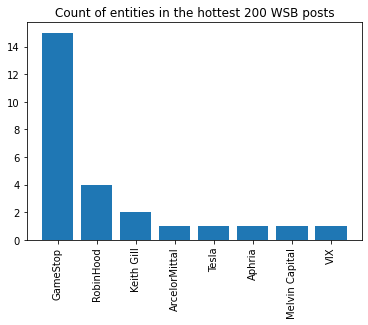

In [21]:
# Plot bar chart
df_plt = pd.DataFrame(counter.items(),columns=['entity','count']).sort_values('count',ascending=False)

plt.bar(df_plt['entity'],df_plt['count'])
plt.xticks(rotation=90)
plt.title('Count of entities in the hottest 200 WSB posts')
plt.show()

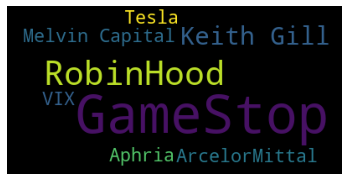

In [22]:
# Word cloud
wordcloud = WordCloud().generate_from_frequencies(counter)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()